As a general rule, the majority of data, be it in a finance context or any other application area, is stored on hard disk drives (HDDs) or some other form of permanent storage device, like solid state disks (SSDs) or hybrid disk drives. Storage capacities have been steadily increasing over the years, while costs per storage unit (e.g., per megabyte) have been steadily falling.

At the same time, stored data volumes have been increasing at a much faster pace than the typical random access memory (RAM) available even in the largest machines. This makes it necessary not only to store data to disk for permanent storage, but also to compensate for lack of sufficient RAM by swapping data from RAM to disk and back.

Input/output (I/O) operations are therefore important tasks when it comes to finance applications and data-intensive applications in general. Often they represent the bottleneck for performance-critical computations, since I/O operations cannot typically shuffle data fast enough to the RAM1 and from the RAM to the disk. In a sense, CPUs are often "starving" due to slow I/O operations.

Although the majority of today's financial and corporate analytics efforts are confronted with big data (e.g., of petascale size), single analytics tasks generally use data subsets that fall in the "mid" data category. A study by Microsoft
Research concludes:

> Our measurements as well as other recent work shows that the majority of real-world analytic jobs process less than 100 GB of input, but popular infrastructures such as Hadoop/MapReduce were originally designed for petascale processing.
>
> Appuswamy et al. (2013)

In terms of frequency, single financial analytics tasks generally process data of not more than a couple of gigabytes (GB) in size — and this is a sweet spot for Python and the libraries of its scientific stack, such as `NumPy`, `pandas`, and `PyTables`. Data sets of such a size can also be analyzed in-memory, leading to generally high speeds with today's CPUs and GPUs. However, the data has to be read into RAM and the results have to be written to disk, meanwhile ensuring that today's performance requirements are met.

This chapter addresses the following topics:

- "Basic I/O with Python"
- "I/O with pandas"
- "I/O with PyTables"
- "I/O with TsTables"

# Basic I/O with Python

Python itself comes with a multitude of I/O capabilities, some optimized for performance, others more for flexibility. In general, however, they are easily used in interactive as well as in production settings.

## Writing Objects to Disk

For later use, for documentation, or for sharing with others, one might want to store Python objects on disk. One option is to use the `pickle` module. This module can serialize the majority of Python objects. *Serialization* refers to the conversion of an object (hierarchy) to a byte stream; *deserialization* is the opposite operation.

As usual, some imports and customizations with regard to plotting first:

In [1]:
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

The example that follows works with (pseudo-)random data, this time stored in a list object:

In [2]:
import pickle    # Imports the pickle module from the standard library.
import numpy as np
from random import gauss    # Import gauss to generate normally distributed random numbers.

In [3]:
a = [gauss(1.5, 2) for i in range(1000000)]    # Creates a larger list object with random numbers.

In [3]:
path = 'data/'    # Specifies the path where to store the data files.

In [5]:
pkl_file = open(path + 'data.pkl', 'wb')    # Opens a file for writing in binary mode ( wb ).

The two major functions to serialize and deserialize Python objects are `pickle.dump()`, for writing objects, and `pickle.load()`, for loading them into memory:

In [6]:
%time pickle.dump(a, pkl_file)    # Serializes the object a and saves it to the file.

CPU times: user 12.9 ms, sys: 8.13 ms, total: 21 ms
Wall time: 20.4 ms


In [7]:
pkl_file.close()    # Closes the file.

In [8]:
ll $path*    # Shows the file on disk and its size (Mac/Linux).

-rw-r--r-- 1 jay 9002006 3月   4 17:55 data/data.pkl


In [9]:
pkl_file = open(path + 'data.pkl', 'rb')    # Opens the file for reading in binary mode ( rb ).

In [10]:
%time b = pickle.load(pkl_file)    # Reads the object from disk and deserializes it.

CPU times: user 16.6 ms, sys: 12 ms, total: 28.6 ms
Wall time: 28.4 ms


In [11]:
a[:3]

[5.458155277768831, 2.1886102392341784, 3.7763880857650896]

In [12]:
b[:3]

[5.458155277768831, 2.1886102392341784, 3.7763880857650896]

In [13]:
# Converting a and b to ndarrary objects, np.allclose() verifies that both
# contain the same data (numbers).
np.allclose(np.array(a), np.array(b))

True

Storing and retrieving a single object with pickle obviously is quite simple. What about two objects?

In [14]:
pkl_file = open(path + 'data.pkl', 'wb')

In [15]:
%time pickle.dump(np.array(a), pkl_file)    # Serializes the ndarray version of a and saves it.

CPU times: user 25 ms, sys: 3.86 ms, total: 28.9 ms
Wall time: 28.2 ms


In [16]:
%time pickle.dump(np.array(a) ** 2, pkl_file)    # Serializes the squared ndarray version of a and saves it.

CPU times: user 26.5 ms, sys: 3.85 ms, total: 30.4 ms
Wall time: 29.6 ms


In [17]:
pkl_file.close()

In [18]:
ll $path*    # The file now has roughly double the size from before.

-rw-r--r-- 1 jay 16000322 3月   4 17:55 data/data.pkl


What about reading the two `ndarray` objects back into memory?

In [19]:
pkl_file = open(path + 'data.pkl', 'rb')

In [20]:
x = pickle.load(pkl_file)    # This retrieves the object that was stored first.
x[:4]

array([5.45815528, 2.18861024, 3.77638809, 4.68802004])

In [21]:
y = pickle.load(pkl_file)    # This retrieves the object that was stored second.
y[:4]

array([29.79145904,  4.79001478, 14.26110697, 21.97753193])

In [22]:
pkl_file.close()

Obviously, `pickle` stores objects according to the *first in, first out* (FIFO) principle. There is one major problem with this: there is no metainformation available to the user to know beforehand what is stored in a `pickle` file.

A sometimes helpful workaround is to not store single objects, but a `dict` object containing all the other objects:

In [23]:
pkl_file = open(path + 'data.pkl', 'wb')
pickle.dump({'x': x, 'y': y}, pkl_file)    # Stores a dict object containing the two ndarray objects.
pkl_file.close()

In [24]:
pkl_file = open(path + 'data.pkl', 'rb')
data = pickle.load(pkl_file)    # Retrieves the dict object.
pkl_file.close()
for key in data.keys():
    print(key, data[key][:4])

x [5.45815528 2.18861024 3.77638809 4.68802004]
y [29.79145904  4.79001478 14.26110697 21.97753193]


In [25]:
!rm -f $path*

This approach requires writing and reading all the objects at once, but this is a compromise one can probably live with in many circumstances given the higher convenience it brings along.

## Reading and Writing Text Files

Text processing can be considered a strength of Python. In fact, many corporate and scientific users use Python for exactly this task. With Python one has multiple options to work with `str` objects, as well as with text files in general.

Assume the case of quite a large set of data that shall be shared as a CSV file. Although such files have a special internal structure, they are basically plain text files. The following code creates a dummy data set as an `ndarray` object, creates a `DatetimeIndex` object, combines the two, and stores the data as a CSV text
file:

In [4]:
import pandas as pd

In [27]:
rows = 5000    # Defines the number of rows for the data set.
a = np.random.standard_normal((rows, 5)).round(4)    # Creates the ndarray object with the random numbers.

In [28]:
a

array([[-0.1727, -0.5909, -1.2599, -1.3193,  0.5751],
       [ 0.8734,  0.77  , -1.6028, -0.8426, -1.3082],
       [ 0.753 , -0.6301, -0.3628,  1.2292,  0.5841],
       ...,
       [ 1.007 ,  0.1174, -0.6352,  0.7424,  0.4923],
       [-1.1124,  0.9849,  0.1769, -1.4268, -1.2996],
       [-1.8144,  0.9849, -2.4821, -0.15  ,  0.0511]])

In [29]:
t = pd.date_range(start='2019/1/1', periods=rows, freq='H')

In [30]:
t    # Creates a DatetimeIndex object of appropriate length (hourly intervals).

DatetimeIndex(['2019-01-01 00:00:00', '2019-01-01 01:00:00',
               '2019-01-01 02:00:00', '2019-01-01 03:00:00',
               '2019-01-01 04:00:00', '2019-01-01 05:00:00',
               '2019-01-01 06:00:00', '2019-01-01 07:00:00',
               '2019-01-01 08:00:00', '2019-01-01 09:00:00',
               ...
               '2019-07-27 22:00:00', '2019-07-27 23:00:00',
               '2019-07-28 00:00:00', '2019-07-28 01:00:00',
               '2019-07-28 02:00:00', '2019-07-28 03:00:00',
               '2019-07-28 04:00:00', '2019-07-28 05:00:00',
               '2019-07-28 06:00:00', '2019-07-28 07:00:00'],
              dtype='datetime64[ns]', length=5000, freq='H')

In [31]:
csv_file = open(path + 'data.csv', 'w')    # Opens a file for writing ( w ).

In [32]:
header = 'date,no1,no2,no3,no4,no5\n'

In [33]:
csv_file.write(header)    # Defines the header row (column labels) and writes it as the first line.

25

In [34]:
for t_, (no1, no2, no3, no4, no5) in zip(t, a):    # Combines the data row-wise ...
    # ... into str objects ...
    s = '{},{},{},{},{},{}\n'.format(t_, no1, no2, no3, no4, no5)
    # ... and writes it line-by-line (appending to the CSV text file).
    csv_file.write(s)

In [35]:
csv_file.close()

In [36]:
ll $path*

-rw-r--r-- 1 jay 284805 3月   4 17:55 data/data.csv


The other way around works quite similarly. First, open the now-existing CSV file. Second, read its content line-by-line using the `.readline()` or `.readlines()` methods of the file object:

In [37]:
csv_file = open(path + 'data.csv', 'r')    # Opens the file for reading ( r ).

In [38]:
for i in range(5):
    print(csv_file.readline(), end='')    # Reads the file contents line-by-line and prints them.

date,no1,no2,no3,no4,no5
2019-01-01 00:00:00,-0.1727,-0.5909,-1.2599,-1.3193,0.5751
2019-01-01 01:00:00,0.8734,0.77,-1.6028,-0.8426,-1.3082
2019-01-01 02:00:00,0.753,-0.6301,-0.3628,1.2292,0.5841
2019-01-01 03:00:00,-0.0699,0.9571,0.0982,-0.1901,-0.5748


In [39]:
csv_file.close()

In [40]:
csv_file = open(path + 'data.csv', 'r')

In [41]:
content = csv_file.readlines()    # Reads the file contents in a single step ...

In [42]:
content[:5]    # ... the result of which is a list object with all lines as separate str objects.

['date,no1,no2,no3,no4,no5\n',
 '2019-01-01 00:00:00,-0.1727,-0.5909,-1.2599,-1.3193,0.5751\n',
 '2019-01-01 01:00:00,0.8734,0.77,-1.6028,-0.8426,-1.3082\n',
 '2019-01-01 02:00:00,0.753,-0.6301,-0.3628,1.2292,0.5841\n',
 '2019-01-01 03:00:00,-0.0699,0.9571,0.0982,-0.1901,-0.5748\n']

In [43]:
csv_file.close()

CSV files are so important and commonplace that there is a `csv` module in the Python standard library that simplifies the processing of these files. Two helpful reader (iterator) objects of the `csv` module return either a `list` of `list` objects or a `list` of `dict` objects:

In [44]:
import csv

In [45]:
with open(path + 'data.csv', 'r') as f:
    csv_reader = csv.reader(f)
    lines = [line for line in csv_reader]

In [46]:
lines[:5]    # csv.reader() returns every single line as a list object.

[['date', 'no1', 'no2', 'no3', 'no4', 'no5'],
 ['2019-01-01 00:00:00', '-0.1727', '-0.5909', '-1.2599', '-1.3193', '0.5751'],
 ['2019-01-01 01:00:00', '0.8734', '0.77', '-1.6028', '-0.8426', '-1.3082'],
 ['2019-01-01 02:00:00', '0.753', '-0.6301', '-0.3628', '1.2292', '0.5841'],
 ['2019-01-01 03:00:00', '-0.0699', '0.9571', '0.0982', '-0.1901', '-0.5748']]

In [47]:
with open(path + 'data.csv', 'r') as f:
    csv_reader = csv.DictReader(f)
    lines = [line for line in csv_reader]

In [48]:
# rcsv.DictReader(f) eturns every single line as an OrderedDict , which is a special case of a dict object.
lines[:3]

[OrderedDict([('date', '2019-01-01 00:00:00'),
              ('no1', '-0.1727'),
              ('no2', '-0.5909'),
              ('no3', '-1.2599'),
              ('no4', '-1.3193'),
              ('no5', '0.5751')]),
 OrderedDict([('date', '2019-01-01 01:00:00'),
              ('no1', '0.8734'),
              ('no2', '0.77'),
              ('no3', '-1.6028'),
              ('no4', '-0.8426'),
              ('no5', '-1.3082')]),
 OrderedDict([('date', '2019-01-01 02:00:00'),
              ('no1', '0.753'),
              ('no2', '-0.6301'),
              ('no3', '-0.3628'),
              ('no4', '1.2292'),
              ('no5', '0.5841')])]

In [49]:
!rm -f $path*

## Working with SQL Databases

Python can work with any kind of Structured Query Language (SQL) database, and in general also with any kind of NoSQL database. One SQL or relational database that is delivered with Python by default is SQLite3. With it, the basic Python approach to SQL databases can be easily illustrated:

In [50]:
import sqlite3 as sq3

In [51]:
con = sq3.connect(path + 'numbs.db')    # Opens a database connection; a file is created if it does not exist.

In [52]:
# A SQL query that creates a table with three columns.
query = 'CREATE TABLE numbs (Date date, No1 real, No2 real)'

In [53]:
con.execute(query)    # Executes the query ...

In [54]:
con.commit()    # ... and commits the changes.

In [55]:
q = con.execute    # Defines a short alias for the con.execute() method.

In [56]:
# Fetches metainformation about the database, showing the just-created table
# as the single object.
q('SELECT * FROM sqlite_master').fetchall()

[('table',
  'numbs',
  'numbs',
  2,
  'CREATE TABLE numbs (Date date, No1 real, No2 real)')]

Now that there is a database file with a table, this table can be populated with data. Each row consists of a `datetime` object and two `float` objects:

In [57]:
import datetime

In [58]:
now = datetime.datetime.now()
q('INSERT INTO numbs VALUES(?, ?, ?)', (now, 0.12, 7.3))
# Writes a single row (or record) to the numbs table.

In [59]:
np.random.seed(100)

In [60]:
data = np.random.standard_normal((10000, 2)).round(4)
# Creates a larger dummy data set as an ndarray object.

In [61]:
%%time
for row in data:    # Iterates over the rows of the ndarray object.
    now = datetime.datetime.now()
    q('INSERT INTO numbs VALUES(?, ?, ?)', (now, row[0], row[1]))
con.commit()

CPU times: user 52 ms, sys: 0 ns, total: 52 ms
Wall time: 53.4 ms


In [62]:
# Retrieves a number of rows from the table.
q('SELECT * FROM numbs').fetchmany(4)

[('2020-03-04 17:55:12.323464', 0.12, 7.3),
 ('2020-03-04 17:55:12.332335', -1.7498, 0.3427),
 ('2020-03-04 17:55:12.332396', 1.153, -0.2524),
 ('2020-03-04 17:55:12.332521', 0.9813, 0.5142)]

In [63]:
# The same, but with a condition on the values in the No1 column.
q('SELECT * FROM numbs WHERE no1 > 0.5').fetchmany(4)

[('2020-03-04 17:55:12.332396', 1.153, -0.2524),
 ('2020-03-04 17:55:12.332521', 0.9813, 0.5142),
 ('2020-03-04 17:55:12.332699', 0.6727, -0.1044),
 ('2020-03-04 17:55:12.332722', 1.619, 1.5416)]

In [64]:
# Defines a pointer object ...
pointer = q('SELECT * FROM numbs')

In [65]:
# ... that behaves like a generator object.
for i in range(3):
    print(pointer.fetchone())

('2020-03-04 17:55:12.323464', 0.12, 7.3)
('2020-03-04 17:55:12.332335', -1.7498, 0.3427)
('2020-03-04 17:55:12.332396', 1.153, -0.2524)


In [66]:
# Retrieves all the remaining rows.
rows = pointer.fetchall()
rows[:3]

[('2020-03-04 17:55:12.332521', 0.9813, 0.5142),
 ('2020-03-04 17:55:12.332644', 0.2212, -1.07),
 ('2020-03-04 17:55:12.332672', -0.1895, 0.255)]

Finally, one might want to delete the table object in the database if it’s not required anymore:

In [67]:
# Removes the table from the database.
q('DROP TABLE IF EXISTS numbs')

In [68]:
# There are no table objects left after this operation.
q('SELECT * FROM sqlite_master').fetchall()

[]

In [69]:
# Closes the database connection.
con.close()

In [70]:
# Removes the database file from disk.
!rm -f $path*

SQL databases are a rather broad topic; indeed, too broad and complex to be covered in any significant way in this chapter. The basic messages are:

- Python integrates well with almost any database technology.
- The basic SQL syntax is mainly determined by the database in use; the rest is what is called "Pythonic."

A few more examples based on SQLite3 are included later in this chapter.

## Writing and Reading NumPy Arrays

`Numpy` itself has functions to write and read `ndarray` objects in a convenient and performant fashion. This saves effort in some circumstances, such as when converting `NumPy` `dtype` objects into specific database data types (e.g., for SQLite3). To illustrate that `NumPy` can be an efficient replacement for a SQL-based approach, the following code replicates the example from the previous section with `NumPy`.

Instead of `pandas`, the code uses the `np.arange()` function of `NumPy` to generate an `ndarray` object with `datetime` objects stored:

In [71]:
# Creates an ndarray object with datetime as the dtype .
dtimes = np.arange('2019-01-01 10:00:00', '2025-12-31 22:00:00',
                   dtype='datetime64[m]')

In [72]:
len(dtimes)

3681360

In [73]:
# Defines the special dtype object for the structured array.
dty = np.dtype([('Date', 'datetime64[m]'),
                ('No1', 'f'), ('No2', 'f')])

In [74]:
# Instantiates an ndarray object with the special dtype .
data = np.zeros(len(dtimes), dtype=dty)

In [75]:
# Populates the Date column.
data['Date'] = dtimes

In [76]:
# The dummy data sets ...
a = np.random.standard_normal((len(dtimes), 2)).round(4)

In [77]:
# ... which populate the No1 and No2 columns.
data['No1'] = a[:, 0]
data['No2'] = a[:, 1]

In [78]:
# The size of the structured array in bytes.
data.nbytes

58901760

Saving of `ndarray` objects is highly optimized and therefore quite fast. Almost 60 MB of data takes a fraction of a second to save on disk (here using an SSD). A larger `ndarray` object with 480 MB of data takes about half a second to save on disk:

In [79]:
# This saves the structured ndarray object on disk.
%time np.save(path + 'array', data)

CPU times: user 0 ns, sys: 21.3 ms, total: 21.3 ms
Wall time: 20.8 ms


In [80]:
ll $path*    # The size on disk is hardly larger than in memory (due to binary storage).

-rw-r--r-- 1 jay 58901888 3月   4 17:55 data/array.npy


In [81]:
# This loads the structured ndarray object from disk.
%time np.load(path + 'array.npy')

CPU times: user 1.54 ms, sys: 8.35 ms, total: 9.89 ms
Wall time: 9.47 ms


array([('2019-01-01T10:00',  1.5131,  0.6973),
       ('2019-01-01T10:01', -1.722 , -0.4815),
       ('2019-01-01T10:02',  0.8251,  0.3019), ...,
       ('2025-12-31T21:57',  1.372 ,  0.6446),
       ('2025-12-31T21:58', -1.2542,  0.1612),
       ('2025-12-31T21:59', -1.1997, -1.097 )],
      dtype=[('Date', '<M8[m]'), ('No1', '<f4'), ('No2', '<f4')])

In [82]:
# A larger regular ndarray object.
%time data = np.random.standard_normal((10000, 6000)).round(4)

CPU times: user 1.07 s, sys: 50.9 ms, total: 1.13 s
Wall time: 1.12 s


In [83]:
data.nbytes

480000000

In [84]:
%time np.save(path + 'array', data)

CPU times: user 3.07 ms, sys: 162 ms, total: 165 ms
Wall time: 164 ms


In [85]:
ll $path*

-rw-r--r-- 1 jay 480000128 3月   4 17:55 data/array.npy


In [86]:
%time np.load(path + 'array.npy')

CPU times: user 0 ns, sys: 71.8 ms, total: 71.8 ms
Wall time: 71 ms


array([[ 0.3066,  0.5951,  0.5826, ...,  1.6773,  0.4294, -0.2216],
       [ 0.8769,  0.7292, -0.9557, ...,  0.5084,  0.9635, -0.4443],
       [-1.2202, -2.5509, -0.0575, ..., -1.6128,  0.4662, -1.3645],
       ...,
       [-0.5598,  0.2393, -2.3716, ...,  1.7669,  0.2462,  1.035 ],
       [ 0.273 ,  0.8216, -0.0749, ..., -0.0552, -0.8396,  0.3077],
       [-0.6305,  0.8331,  1.3702, ...,  0.3493,  0.1981,  0.2037]])

In [87]:
!rm -f $path*

These examples illustrate that writing to disk in this case is mainly hardware-bound, since the speeds observed represent roughly the advertised writing speed of standard SSDs at the time of this writing (about 500 MB/s).

In any case, one can expect that this form of data storage and retrieval is faster when compared to SQL databases or using the `pickle` module for serialization. There are two reasons: first, the data is mainly numeric; second, `NumPy` uses **binary storage**, which reduces the overhead almost to zero. Of course, one does not have the functionality of a SQL database available with this approach, but `PyTables` will help in this regard, as subsequent sections show.

# I/O with pandas

One of the major strengths of `pandas` is that it can read and write different data formats natively, including:

- CSV (comma-separated values)
- SQL (Structured Query Language)
- XLS/XSLX (Microsoft Excel files)
- JSON (JavaScript Object Notation)
- HTML (HyperText Markup Language)

The test case is again a larger set of float objects:

In [88]:
data = np.random.standard_normal((1000000, 5)).round(4)

In [89]:
data[:3]

array([[ 0.4918,  1.3707,  0.137 ,  0.3981, -1.0059],
       [ 0.4516,  1.4445,  0.0555, -0.0397,  0.44  ],
       [ 0.1629, -0.8473, -0.8223, -0.4621, -0.5137]])

To this end, this section also revisits SQLite3 and compares the performance to alternative formats using `pandas`.

## Working with SQL Databases

All that follows with regard to SQLite3 should be familiar by now:

In [90]:
filename = path + 'numbers'

In [91]:
con = sq3.Connection(filename + '.db')

In [92]:
# Creates a table with five columns for real numbers ( float objects).
query = 'CREATE TABLE numbers (No1 real, No2 real,\
        No3 real, No4 real, No5 real)'

In [93]:
q = con.execute
qm = con.executemany

In [94]:
q(query)

This time, the `.executemany()` method can be applied since the data is available in a single ndarray object. Reading and working with the data works as before. Query results can also be visualized easily:

In [95]:
%%time
# Inserts the whole data set into the table in a single step.
qm('INSERT INTO numbers VALUES (?, ?, ?, ?, ?)', data)
con.commit()

CPU times: user 3.96 s, sys: 45.9 ms, total: 4 s
Wall time: 4.03 s


In [96]:
ll $path*

-rw-r--r-- 1 jay 52633600 3月   4 17:55 data/numbers.db


In [97]:
%%time
# Retrieves all the rows from the table in a single step.
temp = q('SELECT * FROM numbers').fetchall()
print(temp[:3])

[(0.4918, 1.3707, 0.137, 0.3981, -1.0059), (0.4516, 1.4445, 0.0555, -0.0397, 0.44), (0.1629, -0.8473, -0.8223, -0.4621, -0.5137)]
CPU times: user 655 ms, sys: 55.9 ms, total: 711 ms
Wall time: 710 ms


In [98]:
%%time
# Retrieves a selection of the rows and transforms it to an ndarray object.
query = 'SELECT * FROM numbers WHERE No1 > 0 AND No2 < 0'
res = np.array(q(query).fetchall()).round(3)

CPU times: user 273 ms, sys: 32.1 ms, total: 305 ms
Wall time: 304 ms


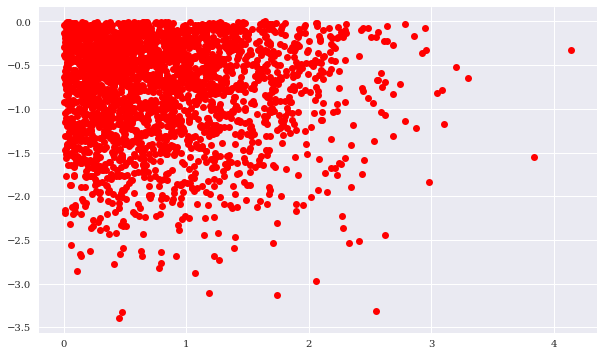

In [99]:
# Plots a subset of the query result.
res = res[::100]
plt.figure(figsize=(10, 6))
plt.plot(res[:, 0], res[:, 1], 'ro')

## From SQL to pandas

A generally more efficient approach, however, is the reading of either whole tables or query results with `pandas`. When one can read a whole table into memory, analytical queries can generally be executed much faster than when using the SQL disk-based approach (out-of-memory).

Reading the whole table with pandas takes roughly the same amount of time as reading it into a `NumPy` `ndarray` object. There as here, the bottleneck performance-wise is the SQL database:

In [100]:
# Reads all rows of the table into the DataFrame object named data .
%time data = pd.read_sql('SELECT * FROM numbers', con)

CPU times: user 983 ms, sys: 87.9 ms, total: 1.07 s
Wall time: 1.07 s


In [101]:
data.head()

,No1,No2,No3,No4,No5
0,0.4918,1.3707,0.1370,0.3981,-1.0059
1,0.4516,1.4445,0.0555,-0.0397,0.4400
2,0.1629,-0.8473,-0.8223,-0.4621,-0.5137
3,1.3064,0.9125,0.5142,-0.7868,-0.3398
4,-0.1148,-1.5215,-0.7045,-1.0042,-0.0600


The data is now in-memory, which allows for much faster analytics. The speedup is often an order of magnitude or more. `pandas` can also master more complex queries, although it is neither meant nor able to replace SQL databases when it comes to complex relational data structures. The result of the query with multiple conditions combined is shown:

In [102]:
# Two conditions combined logically.
%time data[(data['No1'] > 0) & (data['No2'] < 0)].head()

CPU times: user 9.39 ms, sys: 116 µs, total: 9.5 ms
Wall time: 9.1 ms


,No1,No2,No3,No4,No5
2,0.1629,-0.8473,-0.8223,-0.4621,-0.5137
5,0.1893,-0.0207,-0.2104,0.9419,0.2551
8,1.4784,-0.3333,-0.7050,0.3586,-0.3937
10,0.8092,-0.9899,1.0364,-1.0453,0.0579
11,0.9065,-0.7757,-0.9267,0.7797,0.0863


In [103]:
%%time
# Four conditions combined logically.
q = '(No1 < -0.5 | No1 > 0.5) & (No2 < -1 | No2 > 1)'
res = data[['No1', 'No2']].query(q)

CPU times: user 26.7 ms, sys: 904 µs, total: 27.6 ms
Wall time: 16.4 ms


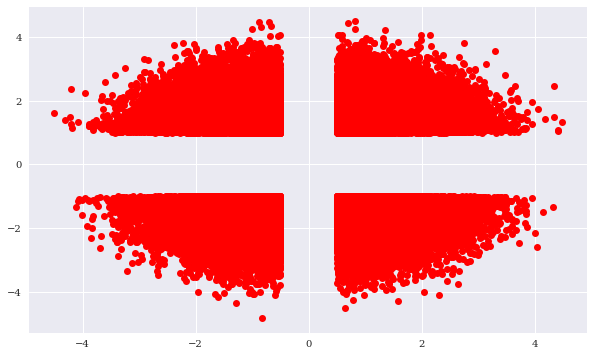

In [104]:
plt.figure(figsize=(10, 6))
plt.plot(res['No1'], res['No2'], 'ro');

As expected, using the in-memory analytics capabilities of `pandas` leads to a significant speedup, provided `pandas` is able to replicate the respective SQL statement.

In [105]:
# This opens an HDF5 database file for writing; in pandas an HDFStore
# object is created.
h5s = pd.HDFStore(filename + '.h5s', 'w')

In [106]:
# The complete DataFrame object is stored in the database file via binary
# storage.
%time h5s['data'] = data

CPU times: user 17.6 ms, sys: 20.2 ms, total: 37.8 ms
Wall time: 37.3 ms


In [107]:
# The HDFStore object information.
h5s

<class 'pandas.io.pytables.HDFStore'>
File path: data/numbers.h5s

In [108]:
# The database file is closed.
h5s.close()

The whole `DataFrame` with all the data from the original SQL table is written much faster when compared to the same procedure with SQLite3. Reading is even faster:

In [109]:
%%time
# This opens the HDF5 database file for reading.
h5s = pd.HDFStore(filename + '.h5s', 'r')
# The DataFrame is read and stored in-memory as data_ .
data_ = h5s['data']
# The database file is closed.
h5s.close()

CPU times: user 7.7 ms, sys: 16.1 ms, total: 23.8 ms
Wall time: 23.1 ms


In [110]:
# The two DataFrame objects are not the same ...
data_ is data

False

In [111]:
# ... but they now contain the same data.
(data_ == data).all()

No1    True
No2    True
No3    True
No4    True
No5    True
dtype: bool

In [112]:
np.allclose(data_, data)

True

In [113]:
ll $path*    # Binary storage generally comes with less size overhead compared to SQL tables, for instance.

-rw-r--r-- 1 jay 52633600 3月   4 17:55 data/numbers.db
-rw-r--r-- 1 jay 48007240 3月   4 17:55 data/numbers.h5s


## Working with CSV Files

One of the most widely used formats to exchange financial data is the CSV format. Although it is not really standardized, it can be processed by any platform and the vast majority of applications concerned with data and financial analytics. Earlier, we saw how to write and read data to and from CSV files with standard Python functionality. `pandas` makes this whole procedure a bit more convenient, the code more concise, and the execution in general faster:

In [114]:
# The .to_csv() method writes the DataFrame data to disk in CSV format.
%time data.to_csv(filename + '.csv')

CPU times: user 3.23 s, sys: 22.8 ms, total: 3.25 s
Wall time: 3.25 s


In [115]:
ll $path

total 141092
-rw-r--r-- 1 jay 43834157 3月   4 17:55 numbers.csv
-rw-r--r-- 1 jay 52633600 3月   4 17:55 numbers.db
-rw-r--r-- 1 jay 48007240 3月   4 17:55 numbers.h5s


In [116]:
# The pd.read_csv() method then reads it back into memory as a new
# DataFrame object.
%time df = pd.read_csv(filename + '.csv')

CPU times: user 266 ms, sys: 20.1 ms, total: 286 ms
Wall time: 285 ms


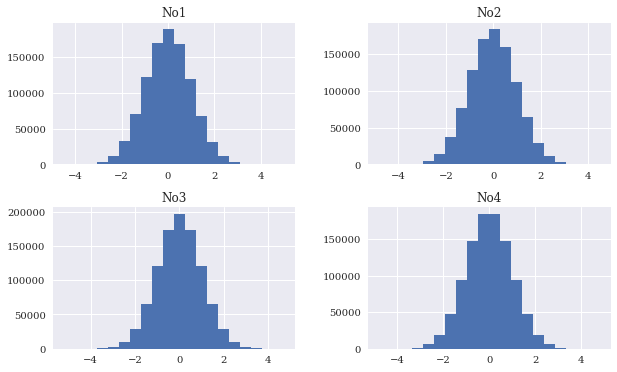

In [117]:
df[['No1', 'No2', 'No3', 'No4']].hist(bins=20, figsize=(10, 6));

## Working with Excel Files

The following code briefly demonstrates how `pandas` can write data in Excel format and read data from Excel spreadsheets. In this case, the data set is restricted to 100,000 rows:

In [118]:
# The .to_excel() method writes the DataFrame data to disk in XLSX
# format.
%time data[:100000].to_excel(filename + '.xlsx', index=False)

CPU times: user 7.63 s, sys: 111 ms, total: 7.74 s
Wall time: 7.75 s


In [119]:
# The pd.read_excel() method then reads it back into memory as a new
# DataFrame object, also specifying the sheet from which to read.
%time df = pd.read_excel(filename + '.xlsx', 'Sheet1')

CPU times: user 3.3 s, sys: 32.1 ms, total: 3.33 s
Wall time: 3.33 s


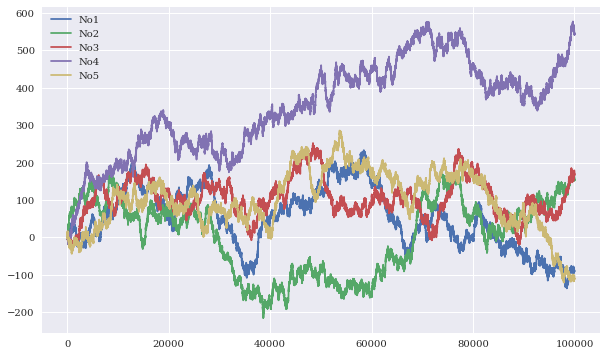

In [120]:
df.cumsum().plot(figsize=(10, 6));

In [121]:
ll $path*

-rw-r--r-- 1 jay 43834157 3月   4 17:55 data/numbers.csv
-rw-r--r-- 1 jay 52633600 3月   4 17:55 data/numbers.db
-rw-r--r-- 1 jay 48007240 3月   4 17:55 data/numbers.h5s
-rw-r--r-- 1 jay  3331870 3月   4 17:55 data/numbers.xlsx


In [122]:
rm -f $path*

Generating the Excel spreadsheet file with a smaller subset of the data takes quite a while. This illustrates what kind of overhead the spreadsheet structure brings along with it.

Inspection of the generated files reveals that the `DataFrame` with `HDFStore` combination is the most compact alternative (using compression, as described in the next section, further increases the benefits). The same amount of data as a CSV file — i.e., as a text file — is somewhat larger in size. This is one reason for the slower performance when working with CSV files, the other being the very fact that they are "only" general text files.

# I/O with PyTables

`PyTables` is a Python binding for the HDF5 database standard. It is specifically designed to optimize the performance of I/O operations and make best use of the available hardware. The library's import name is `tables`. Similar to pandas, when it comes to in-memory analytics `PyTables` is neither able nor meant to be a
**full replacement** for SQL databases. However, it brings along some features that further close the gap. For example, a `PyTables` database can have **many tables**, and it supports compression and indexing and also nontrivial queries on tables. In addition, it can store `NumPy` arrays efficiently and has its own flavor of array-like data structures.

To begin with, some imports:

In [5]:
# The package name is PyTables , the import name is tables .
import tables as tb
import datetime as dt

## Working with Tables

`PyTables` provides a **file-based** database format, similar to SQLite3. The following opens a database file and creates a table:

In [124]:
filename = path + 'pytab.h5'

In [125]:
# Opens the database file in HDF5 binary storage format.
h5 = tb.open_file(filename, 'w')

In [126]:
row_des = {
    'Date': tb.StringCol(26, pos=1),    # The Date column for date-time information (as a str object).
    'No1': tb.IntCol(pos=2),    # The two columns to store int objects.
    'No2': tb.IntCol(pos=3),
    'No3': tb.Float64Col(pos=4),    # The two columns to store float objects.
    'No4': tb.Float64Col(pos=5)
    }

In [127]:
rows = 2000000

In [128]:
# Via Filters objects, compression levels can be specified, among other
# things.
filters = tb.Filters(complevel=0)

In [129]:
tab = h5.create_table('/', 'ints_floats',    # The node (path) and technical name of the table.
                      row_des,    # The description of the row data structure.
                      title='Integers and Floats',    # The name (title) of the table.
                      expectedrows=rows,    # The expected number of rows; allows for optimizations.
                      filters=filters)    # The Filters object to be used for the table.

In [130]:
type(tab)

tables.table.Table

In [131]:
tab

/ints_floats (Table(0,)) 'Integers and Floats'
  description := {
  "Date": StringCol(itemsize=26, shape=(), dflt=b'', pos=0),
  "No1": Int32Col(shape=(), dflt=0, pos=1),
  "No2": Int32Col(shape=(), dflt=0, pos=2),
  "No3": Float64Col(shape=(), dflt=0.0, pos=3),
  "No4": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (2621,)

To populate the table with numerical data, two `ndarray` objects with random numbers are generated: one with random integers, the other with random floating-point numbers. The population of the table happens via a simple Python loop:

In [132]:
# A pointer object is created.
pointer = tab.row

In [133]:
# The ndarray object with the random int objects is created.
ran_int = np.random.randint(0, 10000, size=(rows, 2))

In [134]:
# The ndarray object with the random float objects is created.
ran_flo = np.random.standard_normal((rows, 2)).round(4)

In [135]:
%%time
# The datetime object and the two int and two float objects are written
# row-by-row.
for i in range(rows):
    pointer['Date'] = dt.datetime.now()
    pointer['No1'] = ran_int[i, 0]
    pointer['No2'] = ran_int[i, 1]
    pointer['No3'] = ran_flo[i, 0]
    pointer['No4'] = ran_flo[i, 1]
    pointer.append()    # The new row is appended.
# All written rows are flushed; i.e., committed as permanent changes.
tab.flush()

CPU times: user 4.6 s, sys: 39.5 ms, total: 4.64 s
Wall time: 4.64 s


In [136]:
# The changes are reflected in the Table object description.
tab

/ints_floats (Table(2000000,)) 'Integers and Floats'
  description := {
  "Date": StringCol(itemsize=26, shape=(), dflt=b'', pos=0),
  "No1": Int32Col(shape=(), dflt=0, pos=1),
  "No2": Int32Col(shape=(), dflt=0, pos=2),
  "No3": Float64Col(shape=(), dflt=0.0, pos=3),
  "No4": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (2621,)

In [137]:
ll $path*

-rw-r--r-- 1 jay 100156248 3月   4 17:55 data/pytab.h5


The Python loop is quite slow in this case. There is a more performant and Pythonic way to accomplish the same result, by the use of `NumPy` structured arrays. Equipped with the complete data set stored in a structured array, the creation of the table boils down to a single line of code. Note that the row description is not needed anymore; `PyTables` uses the `dtype` object of the structured array to infer the data types instead:

In [138]:
# This defines the special dtype object.
dty = np.dtype([('Date', 'S26'), ('No1', '<i4'), ('No2', '<i4'),
                ('No3', '<f8'), ('No4', '<f8')])

In [139]:
# This creates the structured array with zeros (and empty strings).
sarray = np.zeros(len(ran_int), dtype=dty)

In [140]:
# A few records from the ndarray object.
sarray[:4]

array([(b'', 0, 0, 0., 0.), (b'', 0, 0, 0., 0.), (b'', 0, 0, 0., 0.),
       (b'', 0, 0, 0., 0.)],
      dtype=[('Date', 'S26'), ('No1', '<i4'), ('No2', '<i4'), ('No3', '<f8'), ('No4', '<f8')])

In [141]:
%%time
# The columns of the ndarray object are populated at once.
sarray['Date'] = dt.datetime.now()
sarray['No1'] = ran_int[:, 0]
sarray['No2'] = ran_int[:, 1]
sarray['No3'] = ran_flo[:, 0]
sarray['No4'] = ran_flo[:, 1]

CPU times: user 36.7 ms, sys: 16.1 ms, total: 52.8 ms
Wall time: 52.2 ms


In [142]:
%%time
# This creates the Table object and populates it with the data.
h5.create_table('/', 'ints_floats_from_array', sarray,
                title='Integers and Floats',
                expectedrows=rows, filters=filters)

CPU times: user 12.6 ms, sys: 32 ms, total: 44.6 ms
Wall time: 44.5 ms


/ints_floats_from_array (Table(2000000,)) 'Integers and Floats'
  description := {
  "Date": StringCol(itemsize=26, shape=(), dflt=b'', pos=0),
  "No1": Int32Col(shape=(), dflt=0, pos=1),
  "No2": Int32Col(shape=(), dflt=0, pos=2),
  "No3": Float64Col(shape=(), dflt=0.0, pos=3),
  "No4": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (2621,)

This approach is an order of magnitude faster, has more concise code, and achieves the same result:

In [143]:
type(h5)

tables.file.File

In [144]:
# The description of the File object with the two Table objects.
h5

File(filename=data/pytab.h5, title='', mode='w', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/ints_floats (Table(2000000,)) 'Integers and Floats'
  description := {
  "Date": StringCol(itemsize=26, shape=(), dflt=b'', pos=0),
  "No1": Int32Col(shape=(), dflt=0, pos=1),
  "No2": Int32Col(shape=(), dflt=0, pos=2),
  "No3": Float64Col(shape=(), dflt=0.0, pos=3),
  "No4": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (2621,)
/ints_floats_from_array (Table(2000000,)) 'Integers and Floats'
  description := {
  "Date": StringCol(itemsize=26, shape=(), dflt=b'', pos=0),
  "No1": Int32Col(shape=(), dflt=0, pos=1),
  "No2": Int32Col(shape=(), dflt=0, pos=2),
  "No3": Float64Col(shape=(), dflt=0.0, pos=3),
  "No4": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (2621,)

In [145]:
# This removes the second Table object with the redundant data.
h5.remove_node('/', 'ints_floats_from_array')

The Table object behaves pretty similar to NumPy structured ndarray objects in most cases:

In [146]:
# Selecting rows via indexing.
tab[:3]

array([(b'2020-03-04 17:55:37.675291', 8576, 5991, -0.0528, 0.2468),
       (b'2020-03-04 17:55:37.675313', 2990, 9310, -0.0261, 0.3932),
       (b'2020-03-04 17:55:37.675316', 4400, 4823,  0.9133, 0.2579)],
      dtype=[('Date', 'S26'), ('No1', '<i4'), ('No2', '<i4'), ('No3', '<f8'), ('No4', '<f8')])

In [147]:
# Selecting column values only via indexing.
tab[:4]['No4']

array([ 0.2468,  0.3932,  0.2579, -0.5582])

In [148]:
# Applying NumPy universal functions.
%time np.sum(tab[:]['No3'])

CPU times: user 6.23 ms, sys: 20 ms, total: 26.2 ms
Wall time: 25.7 ms


88.8542999999997

In [149]:
%time np.sum(np.sqrt(tab[:]['No1']))

CPU times: user 10.6 ms, sys: 20.1 ms, total: 30.7 ms
Wall time: 30.1 ms


133349920.3689251

CPU times: user 55.1 ms, sys: 20 ms, total: 75.1 ms
Wall time: 74.4 ms


(array([1.00000e+00, 0.00000e+00, 2.00000e+00, 2.00000e+01, 1.10000e+02,
        3.80000e+02, 1.32900e+03, 4.13500e+03, 1.09250e+04, 2.58570e+04,
        5.34720e+04, 9.70230e+04, 1.55324e+05, 2.16504e+05, 2.66456e+05,
        2.87214e+05, 2.73180e+05, 2.26867e+05, 1.65167e+05, 1.06402e+05,
        5.99730e+04, 2.96140e+04, 1.28280e+04, 4.93100e+03, 1.64700e+03,
        4.64000e+02, 1.29000e+02, 4.00000e+01, 5.00000e+00, 1.00000e+00]),
 array([-5.6489 , -5.28648, -4.92406, -4.56164, -4.19922, -3.8368 ,
        -3.47438, -3.11196, -2.74954, -2.38712, -2.0247 , -1.66228,
        -1.29986, -0.93744, -0.57502, -0.2126 ,  0.14982,  0.51224,
         0.87466,  1.23708,  1.5995 ,  1.96192,  2.32434,  2.68676,
         3.04918,  3.4116 ,  3.77402,  4.13644,  4.49886,  4.86128,
         5.2237 ]),
 <a list of 30 Patch objects>)

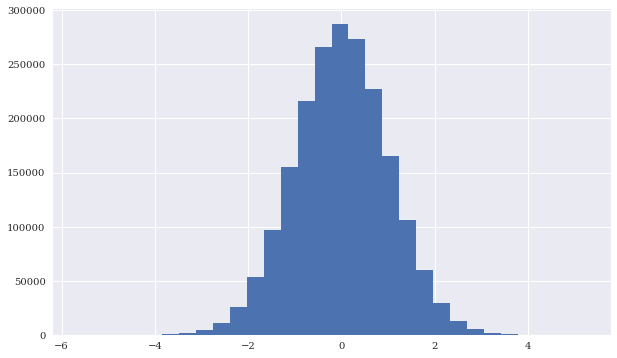

In [150]:
%%time
# Plotting a column from the Table object.
plt.figure(figsize=(10, 6))
plt.hist(tab[:]['No3'], bins=30);

`PyTables` also provides flexible tools to query data via typical SQL-like statements, as in the following example:

In [151]:
# The query as a str object, four conditions combined by logical operators.
query = '((No3 < -0.5) | (No3 > 0.5)) & ((No4 < -1) | (No4 > 1))'

In [152]:
# The iterator object based on the query.
iterator = tab.where(query)

In [153]:
# The rows resulting from the query are collected via a list comprehension ...
%time res = [(row['No3'], row['No4']) for row in iterator]

CPU times: user 169 ms, sys: 17.4 ms, total: 187 ms
Wall time: 98.8 ms


In [154]:
# ... and transformed to an ndarray object.
res = np.array(res)
res[:3]

array([[0.7694, 1.4866],
       [0.9201, 1.3346],
       [1.4701, 1.8776]])

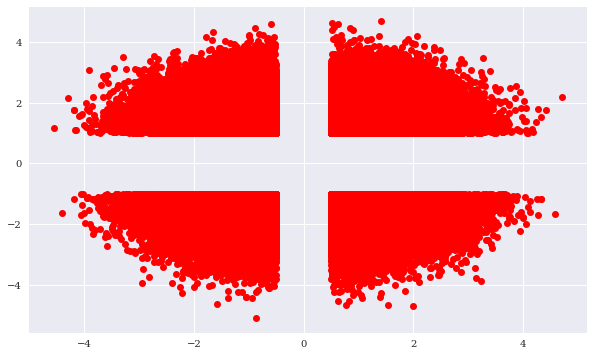

In [155]:
plt.figure(figsize=(10, 6))
plt.plot(res.T[0], res.T[1], 'ro');

As the following examples show, working with data stored in `PyTables` as `Table` objects gives the impression of working with `NumPy` or `pandas` objects in-memory, both from a *syntax* and a *performance* point of view:

In [156]:
%%time
values = tab[:]['No3']
print('Max %18.3f' % values.max())
print('Ave %18.3f' % values.mean())
print('Min %18.3f' % values.min())
print('Std %18.3f' % values.std())

Max              5.224
Ave              0.000
Min             -5.649
Std              1.000
CPU times: user 23.5 ms, sys: 24 ms, total: 47.6 ms
Wall time: 46 ms


In [157]:
%%time
res = [(row['No1'], row['No2']) for row in tab.where(
    '((No1 > 9800) | (No1 < 200)) & ((No2 > 4500) & (No2 < 5500))')]

CPU times: user 45 ms, sys: 25.7 ms, total: 70.7 ms
Wall time: 31.4 ms


In [158]:
for r in res[:4]: print(r)

(91, 4870)
(9803, 5026)
(9846, 4859)
(9823, 5069)


In [159]:
%%time
res = [(row['No1'], row['No2']) for row in tab.where('(No1 == 1234) & (No2 > 9776)')]

CPU times: user 31.5 ms, sys: 15.3 ms, total: 46.9 ms
Wall time: 25.4 ms


In [160]:
for r in res: print(r)

(1234, 9841)
(1234, 9821)
(1234, 9867)
(1234, 9987)
(1234, 9849)
(1234, 9800)


## Working with Compressed Tables

A major advantage of working with `PyTables` is the approach it takes to compression. It uses compression not only to save space on disk, but also to improve the performance of I/O operations in certain hardware scenarios. How
does this work? When I/O is the bottleneck and the CPU is able to (de)compress data fast, the net effect of compression in terms of speed might be positive. Since the following examples are based on the I/O of a standard SSD, there is no speed advantage of compression to be observed. However, there is also almost no *disadvantage* to using compression:

In [161]:
filename = path + 'pytabc.h5'

In [162]:
h5c = tb.open_file(filename, 'w')

In [163]:
# The complevel (compression level) parameter can take values between 0
# (no compression) and 9 (highest compression).
filters = tb.Filters(complevel=5,
                     complib='blosc')
# The Blosc compression engine is used, which is optimized for performance.

In [164]:
tabc = h5c.create_table('/', 'ints_floats', sarray,
                        title='Integers and Floats',
                        expectedrows=rows, filters=filters)

In [165]:
query = '((No3 < -0.5) | (No3 > 0.5)) & ((No4 < -1) | (No4 > 1))'

In [166]:
# This creates the iterator object, based on the query from before.
iteratorc = tabc.where(query)

In [167]:
# The rows resulting from the query are collected via a list comprehension.
%time res = [(row['No3'], row['No4']) for row in iteratorc]

CPU times: user 176 ms, sys: 13.9 ms, total: 190 ms
Wall time: 111 ms


In [168]:
res = np.array(res)
res[:3]

array([[0.7694, 1.4866],
       [0.9201, 1.3346],
       [1.4701, 1.8776]])

Generating the compressed Table object with the original data and doing analytics on it is slightly slower compared to the uncompressed `Table` object. What about reading the data into an `ndarray` object? Let's check:

In [169]:
# Reading from the uncompressed Table object tab .
%time arr_non = tab.read()

CPU times: user 4.31 ms, sys: 16.1 ms, total: 20.4 ms
Wall time: 19.9 ms


In [170]:
tab.size_on_disk

100122200

In [171]:
arr_non.nbytes

100000000

In [172]:
%time arr_com = tabc.read()

CPU times: user 8.96 ms, sys: 24.2 ms, total: 33.1 ms
Wall time: 33 ms


In [173]:
tabc.size_on_disk

41296966

In [174]:
arr_com.nbytes

100000000

In [175]:
ll $path*    # Comparing the sizes — the size of the compressed table is significantly reduced.

-rw-r--r-- 1 jay  41332262 3月   4 17:55 data/pytabc.h5
-rw-r--r-- 1 jay 200312336 3月   4 17:55 data/pytab.h5


In [176]:
# Closing the database file.
h5c.close()

The examples show that there is hardly any speed difference when working with compressed Table objects as compared to uncompressed ones. However, file sizes on disk might - depending on the quality of the data - be significantly reduced, which has a number of benefits:

- Storage costs are reduced.
- Backup costs are reduced.
- Network traffic is reduced.
- Network speed is improved (storage on and retrieval from remote servers is faster).
- CPU utilization is increased to overcome I/O bottlenecks.

## Working with Arrays

"Basic I/O with Python" showed that `NumPy` has built-in fast writing and reading capabilities for `ndarray` objects. `PyTables` is also quite fast and efficient when it comes to storing and retrieving `ndarray` objects, and since it is based on a hierarchical database structure, many convenience features come on top:

In [177]:
%%time
# Stores the ran_int ndarray object.
arr_int = h5.create_array('/', 'integers', ran_int)
# Stores the ran_flo ndarray object.
arr_flo = h5.create_array('/', 'floats', ran_flo)

CPU times: user 0 ns, sys: 23.3 ms, total: 23.3 ms
Wall time: 23.3 ms


In [178]:
h5    # The changes are reflected in the object description.

File(filename=data/pytab.h5, title='', mode='w', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/floats (Array(2000000, 2)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/integers (Array(2000000, 2)) ''
  atom := Int64Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/ints_floats (Table(2000000,)) 'Integers and Floats'
  description := {
  "Date": StringCol(itemsize=26, shape=(), dflt=b'', pos=0),
  "No1": Int32Col(shape=(), dflt=0, pos=1),
  "No2": Int32Col(shape=(), dflt=0, pos=2),
  "No3": Float64Col(shape=(), dflt=0.0, pos=3),
  "No4": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (2621,)

In [179]:
ll $path*

-rw-r--r-- 1 jay  41332262 3月   4 17:55 data/pytabc.h5
-rw-r--r-- 1 jay 262344490 3月   4 17:55 data/pytab.h5


In [180]:
h5.close()

In [181]:
!rm -f $path*

Writing these objects directly to an HDF5 database is faster than looping over the objects and writing the data row-by-row to a Table object or using the approach via structured ndarray objects.

## Out-of-Memory Computations

`PyTables` supports out-of-memory operations, which makes it possible to implement array-based computations that do not fit in memory. To this end, consider the following code based on the `EArray` class. This type of object can be expanded in one dimension (row-wise), while the number of columns (elements per row) needs to be fixed:

In [182]:
filename = path + 'earray.h5'

In [183]:
h5 = tb.open_file(filename, 'w')

In [184]:
n = 500    # The fixed number of columns.

In [185]:
ear = h5.create_earray('/', 'ear',    # The path and technical name of the EArray object.
                       atom=tb.Float64Atom(),    # The atomic dtype object of the single values.
                       shape=(0, n))    # The shape for instantiation (no rows, n columns).

In [186]:
type(ear)

tables.earray.EArray

In [187]:
# The ndarray object with the random numbers ...
rand = np.random.standard_normal((n, n))
rand[:4, :4]

array([[-1.25983231,  1.11420699,  0.1667485 ,  0.7345676 ],
       [-0.13785424,  1.22232417,  1.36303097,  0.13521042],
       [ 1.45487119, -1.47784078,  0.15027672,  0.86755989],
       [-0.63519366,  0.1516327 , -0.64939447, -0.45010975]])

In [188]:
%%time
# ... that gets appended many times.
for _ in range(750):
    ear.append(rand)
ear.flush()

CPU times: user 187 ms, sys: 454 ms, total: 641 ms
Wall time: 641 ms


In [189]:
ear

/ear (EArray(375000, 500)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (16, 500)

In [190]:
ear.size_on_disk

1500032000

For out-of-memory computations that do not lead to aggregations, another `EArray` object of the same shape (size) is needed. `PyTables` has a special module to cope with numerical expressions efficiently. It is called `Expr` and is based on the numerical expression library `numexpr`. The code that follows uses `Expr` to calculate the mathematical expression in Equation \ref{ear-eg} on the whole `EArray` object from before.

\begin{equation}
y  = 3 \sin (x) + \sqrt{\mid x \mid} \label{ear-eg}
\end{equation}

The results are stored in the `out` `EArray` object, and the expression evaluation happens chunk-wise:

In [191]:
out = h5.create_earray('/', 'out',
                       atom=tb.Float64Atom(),
                       shape=(0, n))

In [192]:
out.size_on_disk

0

In [193]:
# Transforms a str object–based expression to an Expr object.
expr = tb.Expr('3 * sin(ear) + sqrt(abs(ear))')

In [194]:
# Defines the output to be the out EArray object.
expr.set_output(out, append_mode=True)

In [195]:
%time expr.eval()    # Initiates the evaluation of the expression.

CPU times: user 1.58 s, sys: 634 ms, total: 2.21 s
Wall time: 1.12 s


/out (EArray(375000, 500)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (16, 500)

In [196]:
out.size_on_disk

1500032000

In [197]:
out[0, :10]

array([-1.73369462,  3.74824436,  0.90627898,  2.86786818,  1.75424957,
       -0.91108973, -1.68313885,  1.29073295, -1.68665599, -1.71345309])

In [198]:
%time out_ = out.read()    # Reads the whole EArray into memory.

CPU times: user 121 ms, sys: 222 ms, total: 343 ms
Wall time: 342 ms


In [199]:
out_[0, :10]

array([-1.73369462,  3.74824436,  0.90627898,  2.86786818,  1.75424957,
       -0.91108973, -1.68313885,  1.29073295, -1.68665599, -1.71345309])

Given that the whole operation takes place out-of-memory, it can be considered quite fast, in particular as it is executed on standard hardware. As a benchmark, the in-memory performance of the `numexpr` module (see also Chapter 10) can be considered. It is faster, but not by a huge margin:

In [200]:
# Imports the module for in-memory evaluations of numerical expressions.
import numexpr as ne

In [201]:
# The numerical expression as a str object.
expr = '3 * sin(out_) + sqrt(abs(out_))'

In [202]:
# Sets the number of threads to one.
ne.set_num_threads(1)

8

In [203]:
# Evaluates the numerical expression in-memory with one thread.
%time ne.evaluate(expr)[0, :10]

CPU times: user 634 ms, sys: 101 ms, total: 734 ms
Wall time: 734 ms


array([-1.64358578,  0.22567882,  3.31363043,  2.50443549,  4.27413965,
       -1.41600606, -1.68373023,  4.01921805, -1.68117412, -1.66053597])

In [204]:
# Sets the number of threads to four.
ne.set_num_threads(4)

1

In [205]:
# Evaluates the numerical expression in-memory with four threads.
%time ne.evaluate(expr)[0, :10]

CPU times: user 692 ms, sys: 108 ms, total: 801 ms
Wall time: 202 ms


array([-1.64358578,  0.22567882,  3.31363043,  2.50443549,  4.27413965,
       -1.41600606, -1.68373023,  4.01921805, -1.68117412, -1.66053597])

In [23]:
h5.close()

In [72]:
!rm -f $path*

# I/O with TsTables

The package `TsTables` uses `PyTables` to build a high-performance storage for time series data. The major usage scenario is "write once, retrieve multiple times." This is a typical scenario in financial analytics, where data is created in the markets, retrieved in real-time or asynchronously, and stored on disk for later usage. That usage might be in a larger trading strategy backtesting program that requires different subsets of a historical financial time series over and over again. It is then important that data retrieval happens fast.

## Sample Data

As usual, the first task is the generation of a sample data set that is large enough to illustrate the benefits of TsTables . The following code generates three rather long financial time series based on the simulation of a geometric Brownian motion (see Chapter 12):

In [12]:
no = 5000000    # The number of time steps.
co = 3    # The number of time series.
interval = 1. / (12 * 30 * 24 * 60)    # The time interval as a year fraction.
vol = .2    # The volatility.

In [13]:
%%time
# Standard normally distributed random numbers.
rn = np.random.standard_normal((no, co))
# Sets the initial random numbers to zero.
rn[0] = 0.0
# The simulation based on an Euler discretization.
paths = 100 * np.exp(np.cumsum(-0.5 * vol ** 2 * interval +
                               vol * np.sqrt(interval) * rn, axis=0))
paths[0] = 100    # Sets the initial values of the paths to 100.

CPU times: user 869 ms, sys: 105 ms, total: 973 ms
Wall time: 972 ms


Since `TsTables` works pretty well with `pandas` `DataFrame` objects, the data is transformed to such an object:

In [14]:
dr = pd.date_range('2019-1-1', periods=no, freq='1s')

In [15]:
dr[-6:]

DatetimeIndex(['2019-02-27 20:53:14', '2019-02-27 20:53:15',
               '2019-02-27 20:53:16', '2019-02-27 20:53:17',
               '2019-02-27 20:53:18', '2019-02-27 20:53:19'],
              dtype='datetime64[ns]', freq='S')

In [16]:
df = pd.DataFrame(paths, index=dr, columns=['ts1', 'ts2', 'ts3'])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000000 entries, 2019-01-01 00:00:00 to 2019-02-27 20:53:19
Freq: S
Data columns (total 3 columns):
ts1    float64
ts2    float64
ts3    float64
dtypes: float64(3)
memory usage: 152.6 MB


In [18]:
df.head()

,ts1,ts2,ts3
2019-01-01 00:00:00,100.000000,100.000000,100.000000
2019-01-01 00:00:01,99.982009,100.049539,100.001004
2019-01-01 00:00:02,99.949375,100.046164,100.004455
2019-01-01 00:00:03,99.963095,100.044310,100.024601
2019-01-01 00:00:04,99.962232,100.060098,100.061264


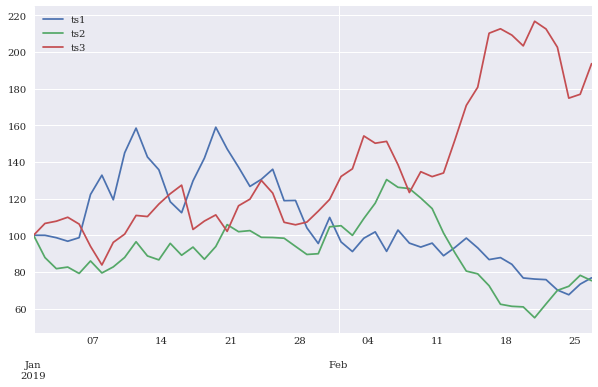

In [19]:
df[::100000].plot(figsize=(10, 6));

## Data Storage

`TsTables` stores financial time series data based on a specific chunk-based structure that allows for fast retrieval of arbitrary data subsets defined by some time interval. To this end, the package adds the function `create_ts()` to `PyTables`. To provide the data types for the table columns, the following uses a method based on the `tb.IsDe⁠scription` class from `PyTables`:

In [52]:
import tstables as tstab

In [53]:
class ts_desc(tb.IsDescription):
    timestamp = tb.Int64Col(pos=0)    # The column for the timestamps.
    ts1 = tb.Float64Col(pos=1)    # The columns to store the numerical data.
    ts2 = tb.Float64Col(pos=2)
    ts3 = tb.Float64Col(pos=3)

In [54]:
h5 = tb.open_file(path + 'tstab.h5', 'w')    # Opens an HDF5 database file for writing ( w ).

In [55]:
ts = h5.create_ts('/', 'ts', ts_desc)    # Creates the TsTable object based on the ts_desc object.

In [56]:
%time ts.append(df)    # Appends the data from the DataFrame object to the TsTable object.

CPU times: user 402 ms, sys: 203 ms, total: 605 ms
Wall time: 604 ms


In [57]:
type(ts)

tstables.tstable.TsTable

In [58]:
ls -n $path

total 312864
-rw-rw-r-- 1 1000 1000 157037368 Mar  4 23:35 tstab.h5
-rw-rw-r-- 1 1000 1000 163328824 Mar  4 23:34 tstabl.h5


## Data Retrieval

Writing data with `TsTables` obviously is quite fast, even if hardware-dependent. The same holds true for reading chunks of the data back into memory. Conveniently, `TsTables` returns a `DataFrame` object:

In [59]:
# The start time of the interval.
read_start_dt = dt.datetime(2019, 2, 1, 0, 0)
# The end time of the interval.
read_end_dt = dt.datetime(2019, 2, 5, 23, 59)

In [60]:
# The function ts.read_range() returns a DataFrame object for the interval.
%time rows = ts.read_range(read_start_dt, read_end_dt)

CPU times: user 54.8 ms, sys: 24.2 ms, total: 79 ms
Wall time: 78.3 ms


In [61]:
# The DataFrame object has a few hundred thousand data rows.
rows.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 431941 entries, 2019-02-01 00:00:00 to 2019-02-05 23:59:00
Data columns (total 3 columns):
ts1    431941 non-null float64
ts2    431941 non-null float64
ts3    431941 non-null float64
dtypes: float64(3)
memory usage: 13.2 MB


In [62]:
rows.head()

,ts1,ts2,ts3
2019-02-01 00:00:00,101.960394,106.307743,133.423421
2019-02-01 00:00:01,102.006088,106.315378,133.402477
2019-02-01 00:00:02,101.962886,106.350633,133.361991
2019-02-01 00:00:03,102.019714,106.409828,133.361396
2019-02-01 00:00:04,102.022671,106.426820,133.401836


In [63]:
h5.close()

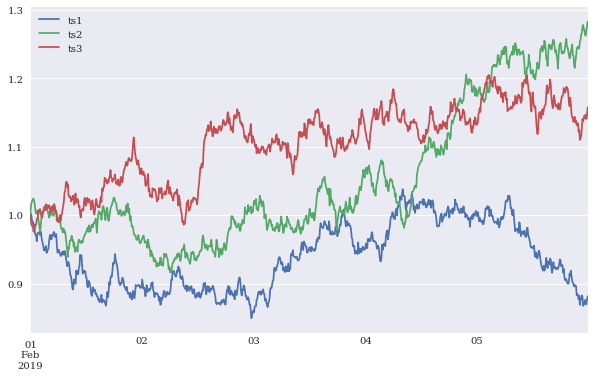

In [64]:
(rows[::500] / rows.iloc[0]).plot(figsize=(10, 6));

To better illustrate the performance of the `TsTables`-based data retrieval, consider the following benchmark, which retrieves 100 chunks of data consisting of 3 days' worth of 1-second bars. The retrieval of a `DataFrame` with 345,600 rows of data takes less than one-tenth of a second:

In [65]:
import random

In [66]:
h5 = tb.open_file(path + 'tstab.h5', 'r')

In [68]:
# This connects to the TsTable object.
ts = h5.root.ts._f_get_timeseries()

In [69]:
%%time
# The data retrieval is repeated many times.
for _ in range(100):
    # The starting day value is randomized.
    d = random.randint(1, 24)
    read_start_dt = dt.datetime(2019, 2, d, 0, 0, 0)
    read_end_dt = dt.datetime(2019, 2, d + 3, 23, 59, 59)
    rows = ts.read_range(read_start_dt, read_end_dt)

CPU times: user 3.98 s, sys: 507 ms, total: 4.48 s
Wall time: 4.48 s


In [70]:
rows.info()    # The last DataFrame object is retrieved.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 345600 entries, 2019-02-22 00:00:00 to 2019-02-25 23:59:59
Data columns (total 3 columns):
ts1    345600 non-null float64
ts2    345600 non-null float64
ts3    345600 non-null float64
dtypes: float64(3)
memory usage: 10.5 MB


In [71]:
!rm $path/tstab.h5

# Conclusion

SQL-based or relational databases have advantages when it comes to complex data structures that exhibit lots of relations between single objects/tables. This might justify in some circumstances their performance disadvantage over pure `NumPy` `ndarray`-based or `pandas` `DataFrame`–based approaches.

Many application areas in finance or science in general can succeed with a mainly array-based data modeling approach. In these cases, huge performance improvements can be realized by making use of native `NumPy` I/O capabilities, a combination of `NumPy` and `PyTables` capabilities, or the pandas approach via HDF5-based stores. `TsTables` is particularly useful when working with large (financial) time series data sets, especially in "write once, retrieve multiple times" scenarios.

While a recent trend has been to use cloud-based solutions - where the cloud is made up of a large number of computing nodes based on commodity hardware - one should carefully consider, especially in a financial context, which hardware architecture best serves the analytics requirements. A study by Microsoft sheds some light on this topic:
> We claim that a single "scale-up" server can process each of these jobs and do as well or better than a cluster in terms of performance, cost, power, and server density.
>
> Appuswamy et al. (2013)

Companies, research institutions, and others involved in data analytics should therefore analyze first what specific tasks have to be accomplished in general and then decide on the hardware/software architecture, in terms of:

- *Scaling out*: 
    Using a cluster with many commodity nodes with standard CPUs and relatively low memory
- *Scaling up*: 
    Using one or a few powerful servers with many-core CPUs, possibly also GPUs or even TPUs when machine and deep learning play a role, and large amounts of memory

Scaling up hardware and applying appropriate implementation approaches might significantly influence performance, which is the focus of the next chapter.